In [106]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [107]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import psycopg2
#import requests
import csv
import os
#import re

#from tensorflow import keras
#from tensorflow.keras import layers
#from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.compat.v1 import set_random_seed


#from imblearn.over_sampling import RandomOverSampler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras. utils.vis_utils import plot_model

# SQL Alchemy
from sqlalchemy import create_engine
from config import username, password

plt.style.use('fivethirtyeight')



In [108]:
start = "2010-01-01"
ticker = "AAPL"

In [109]:
import yfinance as yf
data = yf.download(ticker, start = start, period = "ytd")
#data_DF = yf.download(ticker, period = "ytd", group_by = 'ticker')

[*********************100%***********************]  1 of 1 completed


In [110]:
data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.515213,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.526478,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.422665,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.410790,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.453411,447610800
2010-01-11,7.600000,7.607143,7.444643,7.503929,6.396484,462229600
2010-01-12,7.471071,7.491786,7.372143,7.418571,6.323724,594459600
2010-01-13,7.423929,7.533214,7.289286,7.523214,6.412925,605892000
2010-01-14,7.503929,7.516429,7.465000,7.479643,6.375782,432894000


In [111]:
data = data.reset_index(level=0)

In [112]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.515213,493729600
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.526478,601904800
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.422665,552160000
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.410790,477131200
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.453411,447610800
...,...,...,...,...,...,...,...
3239,2022-11-14,148.970001,150.279999,147.429993,148.279999,148.279999,73374100
3240,2022-11-15,152.220001,153.589996,148.559998,150.039993,150.039993,89868300
3241,2022-11-16,149.130005,149.869995,147.289993,148.789993,148.789993,64218300
3242,2022-11-17,146.429993,151.479996,146.149994,150.720001,150.720001,80389400


In [113]:
print(len(data))

3244


In [114]:
df_ticker= data.drop_duplicates()
print(df_ticker.count())

Date         3244
Open         3244
High         3244
Low          3244
Close        3244
Adj Close    3244
Volume       3244
dtype: int64


In [115]:
# Rename the columns
df_ticker = df_ticker.rename(columns={
'Date': 'Date',  
'Open': 'open',
'High': 'high',
'Low': 'low',
'Close': 'close',
'Adj Close': 'adjclose',
'Volume': 'volume'
})

In [116]:
df_ticker.dtypes

Date        datetime64[ns]
open               float64
high               float64
low                float64
close              float64
adjclose           float64
volume               int64
dtype: object

In [193]:
print('Number of rows and columns: ', df_ticker.shape)
print(df_ticker.head())
print("checking if any null values are present\n", df_ticker.isna().sum())

Number of rows and columns:  (3244, 7)
        Date      open      high       low     close  adjclose     volume
0 2010-01-04  7.622500  7.660714  7.585000  7.643214  6.515213  493729600
1 2010-01-05  7.664286  7.699643  7.616071  7.656429  6.526478  601904800
2 2010-01-06  7.656429  7.686786  7.526786  7.534643  6.422665  552160000
3 2010-01-07  7.562500  7.571429  7.466071  7.520714  6.410790  477131200
4 2010-01-08  7.510714  7.571429  7.466429  7.570714  6.453411  447610800
checking if any null values are present
 Date        0
open        0
high        0
low         0
close       0
adjclose    0
volume      0
dtype: int64


In [122]:
df_ticker.to_csv(f'/content/{ticker}.csv', sep=',', index=True)

Loading ticker data to sqlite stocks database

In [194]:
# Create Engine for project4 data
import sqlite3 as sl
conn=create_engine("sqlite:////content/stocks.db")

In [195]:
#uploading to respecive tables in project2 database
df_ticker.to_sql(ticker, con=conn, if_exists='replace', index=False)

In [123]:
# get treasury data
# merging two csv files
df_treasury = pd.concat(
    map(pd.read_csv, ['daily-treasury-rates.csv', 'yield-curve-rates-1990-2021.csv']), ignore_index=True)
print(df_treasury)

            Date  1 Mo  2 Mo  3 Mo  4 Mo  6 Mo  1 Yr  2 Yr  3 Yr  5 Yr  7 Yr  \
0     11/18/2022  3.93  4.23  4.34  4.46  4.61  4.74  4.51  4.28  3.99  3.92   
1     11/17/2022  3.93  4.20  4.32  4.44  4.57  4.68  4.43  4.22  3.93  3.87   
2     11/16/2022  3.81  4.15  4.32  4.43  4.54  4.62  4.35  4.13  3.83  3.77   
3     11/15/2022  3.77  4.10  4.31  4.40  4.54  4.60  4.37  4.17  3.93  3.88   
4     11/14/2022  3.72  4.05  4.34  4.38  4.55  4.63  4.40  4.24  4.00  3.95   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
8224      1/8/90   NaN   NaN  7.79   NaN  7.88  7.81  7.90  7.95  7.92  8.05   
8225      1/5/90   NaN   NaN  7.79   NaN  7.85  7.79  7.90  7.94  7.92  8.03   
8226      1/4/90   NaN   NaN  7.84   NaN  7.90  7.82  7.92  7.93  7.91  8.02   
8227      1/3/90   NaN   NaN  7.89   NaN  7.94  7.85  7.94  7.96  7.92  8.04   
8228      1/2/90   NaN   NaN  7.83   NaN  7.89  7.81  7.87  7.90  7.87  7.98   

      10 Yr  20 Yr  30 Yr  
0      3.82

In [124]:
df_treasury.dtypes

Date      object
1 Mo     float64
2 Mo     float64
3 Mo     float64
4 Mo     float64
6 Mo     float64
1 Yr     float64
2 Yr     float64
3 Yr     float64
5 Yr     float64
7 Yr     float64
10 Yr    float64
20 Yr    float64
30 Yr    float64
dtype: object

In [125]:
df_treasury['Date'] = pd.to_datetime(df_treasury['Date'])

In [126]:
df_treasury.dtypes

Date     datetime64[ns]
1 Mo            float64
2 Mo            float64
3 Mo            float64
4 Mo            float64
6 Mo            float64
1 Yr            float64
2 Yr            float64
3 Yr            float64
5 Yr            float64
7 Yr            float64
10 Yr           float64
20 Yr           float64
30 Yr           float64
dtype: object

In [127]:
df_treasury

,Date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,2022-11-18,3.93,4.23,4.34,4.46,4.61,4.74,4.51,4.28,3.99,3.92,3.82,4.13,3.92
1,2022-11-17,3.93,4.20,4.32,4.44,4.57,4.68,4.43,4.22,3.93,3.87,3.77,4.10,3.89
2,2022-11-16,3.81,4.15,4.32,4.43,4.54,4.62,4.35,4.13,3.83,3.77,3.67,4.03,3.85
3,2022-11-15,3.77,4.10,4.31,4.40,4.54,4.60,4.37,4.17,3.93,3.88,3.80,4.20,3.98
4,2022-11-14,3.72,4.05,4.34,4.38,4.55,4.63,4.40,4.24,4.00,3.95,3.88,4.28,4.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8224,1990-01-08,NaN,NaN,7.79,NaN,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09
8225,1990-01-05,NaN,NaN,7.79,NaN,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
8226,1990-01-04,NaN,NaN,7.84,NaN,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
8227,1990-01-03,NaN,NaN,7.89,NaN,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04


In [128]:
# Finally, merge all tables
df = pd.merge(df_ticker, df_treasury, how='inner', on='Date')
df

,Date,open,high,low,close,adjclose,volume,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.515213,493729600,0.05,NaN,0.08,NaN,0.18,0.45,1.09,1.66,2.65,3.36,3.85,4.60,4.65
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.526478,601904800,0.03,NaN,0.07,NaN,0.17,0.41,1.01,1.57,2.56,3.28,3.77,4.54,4.59
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.422665,552160000,0.03,NaN,0.06,NaN,0.15,0.40,1.01,1.60,2.60,3.33,3.85,4.63,4.70
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.410790,477131200,0.02,NaN,0.05,NaN,0.16,0.40,1.03,1.62,2.62,3.33,3.85,4.62,4.69
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.453411,447610800,0.02,NaN,0.05,NaN,0.15,0.37,0.96,1.56,2.57,3.31,3.83,4.61,4.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,2022-11-14,148.970001,150.279999,147.429993,148.279999,148.279999,73374100,3.72,4.05,4.34,4.38,4.55,4.63,4.40,4.24,4.00,3.95,3.88,4.28,4.07
3216,2022-11-15,152.220001,153.589996,148.559998,150.039993,150.039993,89868300,3.77,4.10,4.31,4.40,4.54,4.60,4.37,4.17,3.93,3.88,3.80,4.20,3.98
3217,2022-11-16,149.130005,149.869995,147.289993,148.789993,148.789993,64218300,3.81,4.15,4.32,4.43,4.54,4.62,4.35,4.13,3.83,3.77,3.67,4.03,3.85
3218,2022-11-17,146.429993,151.479996,146.149994,150.720001,150.720001,80389400,3.93,4.20,4.32,4.44,4.57,4.68,4.43,4.22,3.93,3.87,3.77,4.10,3.89


In [129]:
# Find null values
for column in df.columns:
    print(f"Column {column} has {df[column].isnull().sum()} null values")

Column Date has 0 null values
Column open has 0 null values
Column high has 0 null values
Column low has 0 null values
Column close has 0 null values
Column adjclose has 0 null values
Column volume has 0 null values
Column 1 Mo has 1 null values
Column 2 Mo has 2197 null values
Column 3 Mo has 1 null values
Column 4 Mo has 3198 null values
Column 6 Mo has 1 null values
Column 1 Yr has 1 null values
Column 2 Yr has 1 null values
Column 3 Yr has 1 null values
Column 5 Yr has 1 null values
Column 7 Yr has 1 null values
Column 10 Yr has 1 null values
Column 20 Yr has 1 null values
Column 30 Yr has 1 null values


In [130]:
df = df.drop(columns =["4 Mo"])
df.head(15)

,Date,open,high,low,close,adjclose,volume,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.515213,493729600,0.05,NaN,0.08,0.18,0.45,1.09,1.66,2.65,3.36,3.85,4.60,4.65
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.526478,601904800,0.03,NaN,0.07,0.17,0.41,1.01,1.57,2.56,3.28,3.77,4.54,4.59
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.422665,552160000,0.03,NaN,0.06,0.15,0.40,1.01,1.60,2.60,3.33,3.85,4.63,4.70
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.410790,477131200,0.02,NaN,0.05,0.16,0.40,1.03,1.62,2.62,3.33,3.85,4.62,4.69
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.453411,447610800,0.02,NaN,0.05,0.15,0.37,0.96,1.56,2.57,3.31,3.83,4.61,4.70
5,2010-01-11,7.600000,7.607143,7.444643,7.503929,6.396484,462229600,0.01,NaN,0.04,0.13,0.35,0.95,1.55,2.58,3.32,3.85,4.64,4.74
6,2010-01-12,7.471071,7.491786,7.372143,7.418571,6.323724,594459600,0.02,NaN,0.05,0.14,0.34,0.92,1.50,2.49,3.22,3.74,4.52,4.62
7,2010-01-13,7.423929,7.533214,7.289286,7.523214,6.412925,605892000,0.02,NaN,0.06,0.15,0.37,0.97,1.54,2.55,3.28,3.80,4.60,4.71
8,2010-01-14,7.503929,7.516429,7.465000,7.479643,6.375782,432894000,0.02,NaN,0.05,0.14,0.34,0.94,1.49,2.51,3.23,3.76,4.52,4.63
9,2010-01-15,7.533214,7.557143,7.352500,7.354643,6.269229,594067600,0.03,NaN,0.06,0.15,0.33,0.89,1.44,2.44,3.17,3.70,4.48,4.58


In [131]:
# Find duplicate entries
print(f"Duplicate entries: {df.duplicated().sum()}")

Duplicate entries: 0


In [132]:
# Renaming the columns
df = df.rename(columns={
'Date': 'date',
'1 Mo': '1mo',
'2 Mo': '2mo',
'3 Mo': '3mo',
'6 Mo': '6mo',
'Year': 'year',
'1 Yr': '1yr',
'2 Yr': '2yr',
'3 Yr': '3yr',
'5 Yr': '5yr',
'7 Yr': '7yr',
'10 Yr': '10yr',
'20 Yr': '20yr',
'30 Yr': '30yr'
})

In [133]:
#df = pd.DataFrame(df)

In [134]:
df = df.set_index('date')

In [135]:
df.to_csv(f'/content/{ticker}.csv', sep=',', index=True)

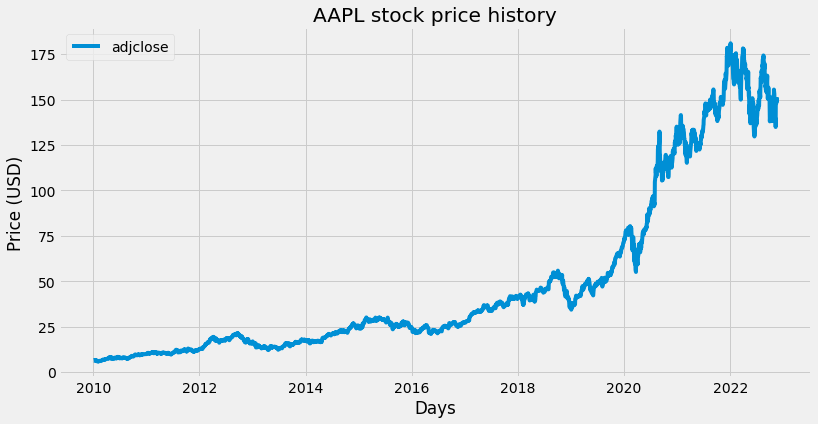

In [136]:
plt.figure(figsize = (12,6))
#plt.plot(df_ticker["open"])
#plt.plot(df_ticker["high"])
#plt.plot(df_ticker["low"])
plt.plot(df["adjclose"])
title_name = ticker+ ' stock price history'
plt.title(title_name)
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['adjclose'], loc='upper left')
#plt.legend(['Open','High','Low','adjclose'], loc='upper left')
plt.show()

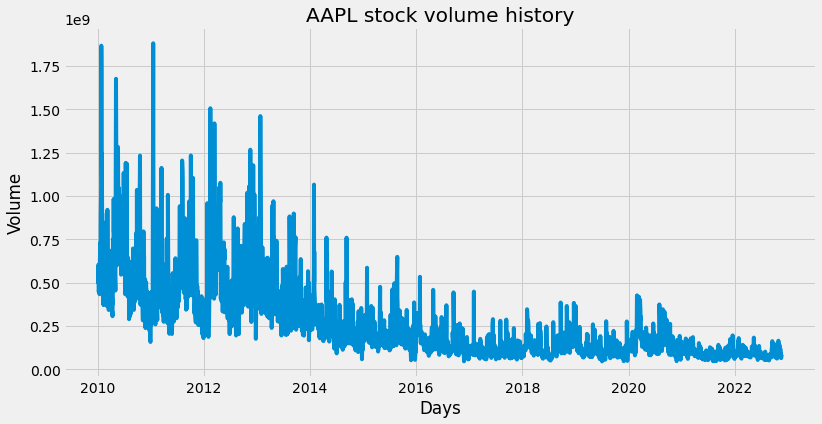

In [137]:
plt.figure(figsize = (12,6))
plt.plot(df["volume"])
title_name = ticker+ ' stock volume history'
plt.title(title_name)
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

#LSTM - Method - 1

In [169]:
#Set Target Variable
output_var = pd.DataFrame(df["adjclose"])
#Selecting the Features
#features = ['open', 'high', 'low', 'volume', '1mo', '2mo', '3mo', '6mo', '1yr', '10yr']
features = ['open', 'high', 'low', 'volume']

In [170]:
#df = df.reset_index(level=0)

In [171]:
df.head(10)

,open,high,low,close,adjclose,volume,1mo,2mo,3mo,6mo,1yr,2yr,3yr,5yr,7yr,10yr,20yr,30yr
date,,,,,,,,,,,,,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.515213,493729600,0.05,NaN,0.08,0.18,0.45,1.09,1.66,2.65,3.36,3.85,4.60,4.65
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.526478,601904800,0.03,NaN,0.07,0.17,0.41,1.01,1.57,2.56,3.28,3.77,4.54,4.59
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.422665,552160000,0.03,NaN,0.06,0.15,0.40,1.01,1.60,2.60,3.33,3.85,4.63,4.70
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.410790,477131200,0.02,NaN,0.05,0.16,0.40,1.03,1.62,2.62,3.33,3.85,4.62,4.69
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.453411,447610800,0.02,NaN,0.05,0.15,0.37,0.96,1.56,2.57,3.31,3.83,4.61,4.70
2010-01-11,7.600000,7.607143,7.444643,7.503929,6.396484,462229600,0.01,NaN,0.04,0.13,0.35,0.95,1.55,2.58,3.32,3.85,4.64,4.74
2010-01-12,7.471071,7.491786,7.372143,7.418571,6.323724,594459600,0.02,NaN,0.05,0.14,0.34,0.92,1.50,2.49,3.22,3.74,4.52,4.62
2010-01-13,7.423929,7.533214,7.289286,7.523214,6.412925,605892000,0.02,NaN,0.06,0.15,0.37,0.97,1.54,2.55,3.28,3.80,4.60,4.71
2010-01-14,7.503929,7.516429,7.465000,7.479643,6.375782,432894000,0.02,NaN,0.05,0.14,0.34,0.94,1.49,2.51,3.23,3.76,4.52,4.63


In [172]:
#Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,open,high,low,volume
date,,,,
2010-01-04,0.004279,0.003755,0.004586,0.244222
2010-01-05,0.004517,0.003977,0.004767,0.303155
2010-01-06,0.004472,0.003904,0.004249,0.276055
2010-01-07,0.003938,0.003248,0.003896,0.235179
2010-01-08,0.003643,0.003248,0.003898,0.219097


#Splitting to Training set and Test set
The sci-kit-learn library’s TimeSeriesSplit class will be used for this. We set the number of splits to 10, indicating that 10% of the data will be used as the test set and 90% of the data would be used to train the LSTM model. The advantage of utilising this Time Series split is that the split time series data samples are examined at regular time intervals.

In [173]:
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

As the LSTM needs that the data to be provided in the 3D form, we first transform the training and test data to NumPy arrays and then restructure them to match into the format (Number of Samples, 1, Number of Features). 

In [174]:
#Process the data for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

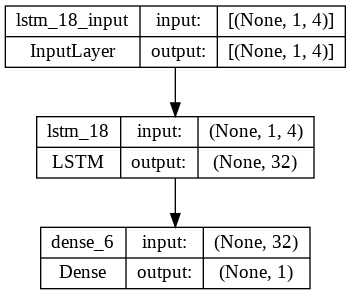

In [175]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True)



In [176]:
print('Number of rows and columns: ', X_train.shape)

Number of rows and columns:  (2928, 1, 4)


# Training the Stock Market Prediction Model

In [177]:
# Fitting the Training set
history= lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100
366/366 [==============================] - 2s 2ms/step - loss: 1948.8837
Epoch 2/100
366/366 [==============================] - 1s 2ms/step - loss: 1243.8629
Epoch 3/100
366/366 [==============================] - 1s 2ms/step - loss: 726.6569
Epoch 4/100
366/366 [==============================] - 1s 2ms/step - loss: 424.5690
Epoch 5/100
366/366 [==============================] - 1s 2ms/step - loss: 283.3767
Epoch 6/100
366/366 [==============================] - 1s 2ms/step - loss: 195.1236
Epoch 7/100
366/366 [==============================] - 1s 2ms/step - loss: 119.0427
Epoch 8/100
366/366 [==============================] - 1s 2ms/step - loss: 59.5736
Epoch 9/100
366/366 [==============================] - 1s 2ms/step - loss: 24.7060
Epoch 10/100
366/366 [==============================] - 1s 2ms/step - loss: 9.5292
Epoch 11/100
366/366 [==============================] - 1s 2ms/step - loss: 4.7100
Epoch 12/100
366/366 [==============================] - 1s 2ms/step - loss: 3.

In [180]:
y_pred.shape

(292, 1)

In [181]:
#LSTM Prediction
y_pred= lstm.predict(X_test)

10/10 [==============================] - 0s 1ms/step


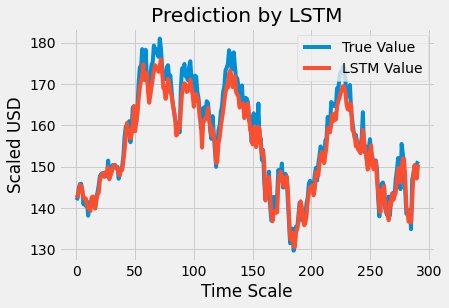

In [182]:
#Predicted vs True Adj Close Value – LSTM
predicted_df = pd.DataFrame(y_test)
predicted_df['predictions'] = y_pred
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title("Prediction by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

In [183]:
predicted_df

,0,predictions
0,141.908081,142.501343
1,142.394531,142.966400
2,144.797073,144.035217
3,145.769989,145.578568
4,145.859360,145.371521
...,...,...
287,148.279999,147.939911
288,150.039993,150.361313
289,148.789993,147.799820
290,150.720001,147.118134


In [184]:
lstm.save("LSTM_Method_1.h5")

#LSTM - Method-2

In [150]:
# Create a dataframe with only the Close Stock Price Column
data_target = df.filter(['close'])

# Convert the dataframe to a numpy array to train the LSTM model
target = data_target.values

# Splitting the dataset into training and test
# Target Variable: Close stock price value

training_data_len = int(len(target)* 0.75) # training set has 75% of the data
training_data_len

# Normalizing data before model fitting using MinMaxScaler
# Feature Scaling

sc = MinMaxScaler(feature_range=(0,1))
training_scaled_data = sc.fit_transform(target)
training_scaled_data

array([[0.00447776],
       [0.00455321],
       [0.00385789],
       ...,
       [0.81033515],
       [0.82135425],
       [0.82460854]])

In [151]:
# Create a training dataset containing the last 180-day closing price values we want to use to estimate the 181st closing price value.
train_data = training_scaled_data[0:training_data_len  , : ]

X_train = []
y_train = []
for i in range(180, len(train_data)):
    X_train.append(train_data[i-180:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train) # converting into numpy sequences to train the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print('Number of rows and columns: ', X_train.shape)  #(854 values, 180 time-steps, 1 output)

Number of rows and columns:  (2235, 180, 1)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 180, 50)           10400     
                                                                 
 dropout_9 (Dropout)         (None, 180, 50)           0         
                                                                 
 lstm_15 (LSTM)              (None, 180, 50)           20200     
                                                                 
 dropout_10 (Dropout)        (None, 180, 50)           0         
                                                                 
 lstm_16 (LSTM)              (None, 180, 50)           20200     
                                                                 
 dropout_11 (Dropout)        (None, 180, 50)           0         
                                                                 
 lstm_17 (LSTM)              (None, 50)               

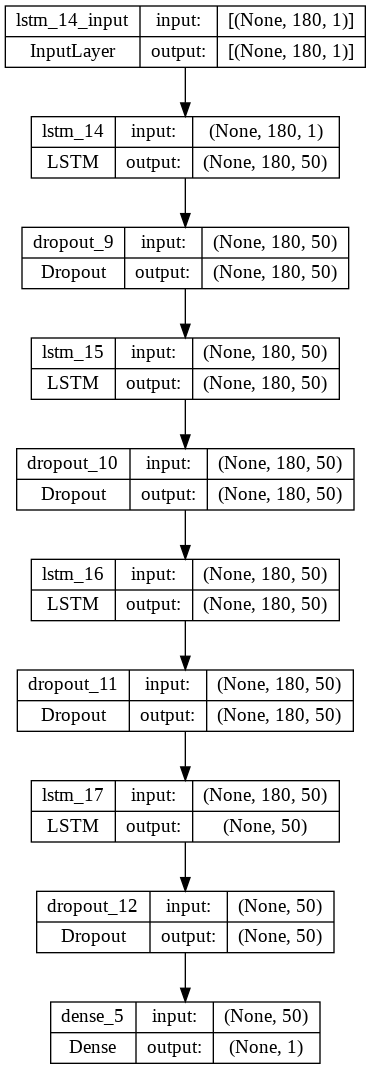

In [152]:
# We add the LSTM layer and later add a few Dropout layers to prevent overfitting.
# Building a LTSM model with 50 neurons and 4 hidden layers. We add the LSTM layer with the following arguments:
# 50 units which is the dimensionality of the output space
# return_sequences=True which determines whether to return the last output in the output sequence, or the full sequence input_shape as the shape of our training set.
# When defining the Dropout layers, we specify 0.2, meaning that 20% of the layers will be dropped.
# Thereafter, we add the Dense layer that specifies the output of 1 unit.
# After this, we compile our model using the popular adam optimizer and set the loss as the mean_squarred_error.

model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics = ['accuracy'])

# Reporting the number of parameters
print(model.summary())
    
num_params = model.count_params()
print('Number of parameters: {}'.format(num_params))
plot_model(model, show_shapes=True, show_layer_names=True)

In [153]:
# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
70/70 [==============================] - 25s 275ms/step - loss: 0.0013 - accuracy: 0.0000e+00
Epoch 2/100
70/70 [==============================] - 17s 246ms/step - loss: 3.3258e-04 - accuracy: 0.0000e+00
Epoch 3/100
70/70 [==============================] - 17s 244ms/step - loss: 2.4371e-04 - accuracy: 0.0000e+00
Epoch 4/100
70/70 [==============================] - 18s 254ms/step - loss: 2.4255e-04 - accuracy: 0.0000e+00
Epoch 5/100
70/70 [==============================] - 17s 245ms/step - loss: 2.1916e-04 - accuracy: 0.0000e+00
Epoch 6/100
70/70 [==============================] - 17s 249ms/step - loss: 1.8092e-04 - accuracy: 0.0000e+00
Epoch 7/100
70/70 [==============================] - 17s 247ms/step - loss: 1.6726e-04 - accuracy: 0.0000e+00
Epoch 8/100
70/70 [==============================] - 17s 246ms/step - loss: 1.8128e-04 - accuracy: 0.0000e+00
Epoch 9/100
70/70 [==============================] - 18s 254ms/step - loss: 1.5294e-04 - accuracy: 0.0000e+00
Epoch 10/100
7

In [157]:
# Getting the predicted stock price
test_data = training_scaled_data[training_data_len - 180: , : ]

#Create the x_test and y_test data sets
X_test = []
y_test =  target[training_data_len : , : ]
for i in range(180,len(test_data)):
    X_test.append(test_data[i-180:i,0])

# Convert x_test to a numpy array
X_test = np.array(X_test)

#Reshape the data into the shape accepted by the LSTM
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print('Number of rows and columns: ', X_test.shape)

Number of rows and columns:  (805, 180, 1)


In [158]:
# Making predictions using the test dataset
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

26/26 [==============================] - 1s 52ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


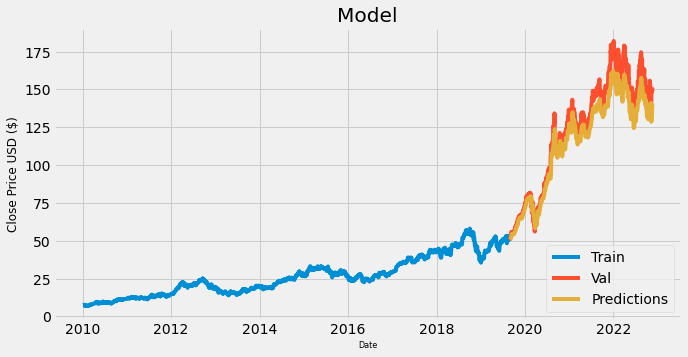

In [159]:
# Visualising the results
train = data_target[:training_data_len]
valid = data_target[training_data_len:]
valid['predictions'] = predicted_stock_price
plt.figure(figsize=(10,5))
plt.title('Model')
plt.xlabel('Date', fontsize=8)
plt.ylabel('Close Price USD ($)', fontsize=12)
plt.plot(train['close'])
plt.plot(valid[['close', 'predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [160]:
valid

,close,predictions
date,,
2019-08-30,52.185001,50.668907
2019-09-03,51.424999,50.973366
2019-09-04,52.297501,51.222363
2019-09-05,53.320000,51.427631
2019-09-06,53.314999,51.746700
...,...,...
2022-11-14,148.279999,131.436844
2022-11-15,150.039993,135.554764
2022-11-16,148.789993,139.273193


In [185]:
#save models
model.save("LSTM_Method_2.h5")